In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import json
from sqlalchemy import create_engine, text

# Set up plotting style
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)

## Load and Explore Data

In [13]:
# Database configuration - update these with your actual values
DB_CONFIG = {
    "host": "127.0.0.1",  # Use 127.0.0.1 if using Cloud SQL proxy locally
    "port": 5432,
    "database": "tts_ratings",
    "user": "tts_ratings_user",  # Replace with your actual username
    "password": "fgek9ovpgH32pyi8",  # Replace with your actual password
}

DB_TABLE = "ratings"  # Default table name

# Create SQLAlchemy engine
db_url = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(db_url)

print("Database connection established.")
print(f"Connected to: {DB_CONFIG['database']} on {DB_CONFIG['host']}")

Database connection established.
Connected to: tts_ratings on 127.0.0.1


In [15]:
# Load ratings data with SQLAlchemy
ratings_query = f"""
    SELECT 
        id,
        user_email,
        audio_file,
        rating,
        timestamp,
        session_info
    FROM {DB_TABLE}
    ORDER BY timestamp DESC
"""

ratings_df = pd.read_sql_query(ratings_query, engine)

print(
    f"Loaded {len(ratings_df)} ratings from {len(ratings_df['user_email'].unique())} unique users"
)

Loaded 11 ratings from 1 unique users


In [18]:
# Display basic info about the data
if ratings_df is not None and not ratings_df.empty:
    print("=== Ratings Data Overview ===")
    print(ratings_df.info())
    print("\n=== First 5 ratings ===")
    display(ratings_df.head())

    print("\n=== Rating distribution ===")
    print(ratings_df["rating"].value_counts().sort_index())
else:
    print("No ratings data available yet.")

=== Ratings Data Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   id            11 non-null     int64              
 1   user_email    11 non-null     object             
 2   audio_file    11 non-null     object             
 3   rating        11 non-null     int64              
 4   timestamp     11 non-null     datetime64[ns, UTC]
 5   session_info  11 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 660.0+ bytes
None

=== First 5 ratings ===


,id,user_email,audio_file,rating,timestamp,session_info
0,11,a.smoliakovas@gmail.com,sentence_01_speaker_VP157_aš_labai_mėgstu_skai...,4,2025-12-02 21:46:05.014474+00:00,{'timestamp': '2025-12-02T21:46:05.014434+00:0...
1,10,a.smoliakovas@gmail.com,sentence_02_speaker_AS022_šiandien_oras_yra_pu...,3,2025-12-02 21:43:43.392259+00:00,{'timestamp': '2025-12-02T21:43:43.392192+00:0...
2,9,a.smoliakovas@gmail.com,sentence_03_speaker_VP157_technologijos_sparči...,3,2025-12-02 21:43:35.829708+00:00,{'timestamp': '2025-12-02T21:43:35.829660+00:0...
3,8,a.smoliakovas@gmail.com,sentence_03_speaker_AS022_technologijos_sparči...,3,2025-12-02 21:40:11.216954+00:00,{'timestamp': '2025-12-02T21:40:11.216922+00:0...
4,7,a.smoliakovas@gmail.com,sentence_01_speaker_AS022_aš_labai_mėgstu_skai...,3,2025-12-02 21:20:17.497664+00:00,{'timestamp': '2025-12-02T21:20:17.497628+00:0...



=== Rating distribution ===
rating
2    2
3    5
4    4
Name: count, dtype: int64


## Data Processing and Feature Engineering

In [19]:
if ratings_df is not None and not ratings_df.empty:
    # Convert timestamp to datetime
    ratings_df["timestamp"] = pd.to_datetime(ratings_df["timestamp"])

    # Extract features from audio filenames
    ratings_df["audio_file_clean"] = ratings_df["audio_file"].str.replace(".wav", "")

    # Try to extract model information from filename patterns
    # Adjust these patterns based on your actual file naming conventions
    def extract_model_info(filename):
        """Extract model and other info from audio filename."""
        filename = filename.lower()

        # Common model patterns
        if "tacotron2" in filename or "tacotron" in filename:
            model = "Tacotron2"
        elif "fastpitch" in filename or "fast_pitch" in filename:
            model = "FastPitch"
        elif "vits" in filename:
            model = "VITS"
        else:
            model = "Unknown"

        # Additional features
        is_multispeaker = "multispeaker" in filename
        has_dca = "dca" in filename
        has_ddc = "ddc" in filename

        return model, is_multispeaker, has_dca, has_ddc

    # Apply feature extraction
    features = ratings_df["audio_file"].apply(extract_model_info)
    ratings_df["model"] = [f[0] for f in features]
    ratings_df["is_multispeaker"] = [f[1] for f in features]
    ratings_df["has_dca"] = [f[2] for f in features]
    ratings_df["has_ddc"] = [f[3] for f in features]

    # Add time-based features
    ratings_df["date"] = ratings_df["timestamp"].dt.date
    ratings_df["hour"] = ratings_df["timestamp"].dt.hour
    ratings_df["day_of_week"] = ratings_df["timestamp"].dt.day_name()

    print("Data processing completed!")
    print(f"\nModel distribution:")
    print(ratings_df["model"].value_counts())

Data processing completed!

Model distribution:
model
Unknown    11
Name: count, dtype: int64


## Overall Statistics

In [20]:
if ratings_df is not None and not ratings_df.empty:
    # Calculate summary statistics
    total_ratings = len(ratings_df)
    unique_users = ratings_df["user_email"].nunique()
    unique_audio_files = ratings_df["audio_file"].nunique()
    avg_rating = ratings_df["rating"].mean()
    median_rating = ratings_df["rating"].median()
    rating_std = ratings_df["rating"].std()

    # Time range
    min_date = ratings_df["timestamp"].min()
    max_date = ratings_df["timestamp"].max()
    date_range = (max_date - min_date).days

    print("=== OVERALL STATISTICS ===")
    print(f"Total ratings: {total_ratings:,}")
    print(f"Unique users: {unique_users:,}")
    print(f"Unique audio files: {unique_audio_files:,}")
    print(f"Average rating: {avg_rating:.2f} ± {rating_std:.2f}")
    print(f"Median rating: {median_rating}")
    print(
        f"Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')} ({date_range} days)"
    )
    print(f"Ratings per user (avg): {total_ratings / unique_users:.1f}")
    print(f"Ratings per audio file (avg): {total_ratings / unique_audio_files:.1f}")

=== OVERALL STATISTICS ===
Total ratings: 11
Unique users: 1
Unique audio files: 11
Average rating: 3.18 ± 0.75
Median rating: 3.0
Date range: 2025-12-02 to 2025-12-02 (0 days)
Ratings per user (avg): 11.0
Ratings per audio file (avg): 1.0


## Rating Distribution Analysis

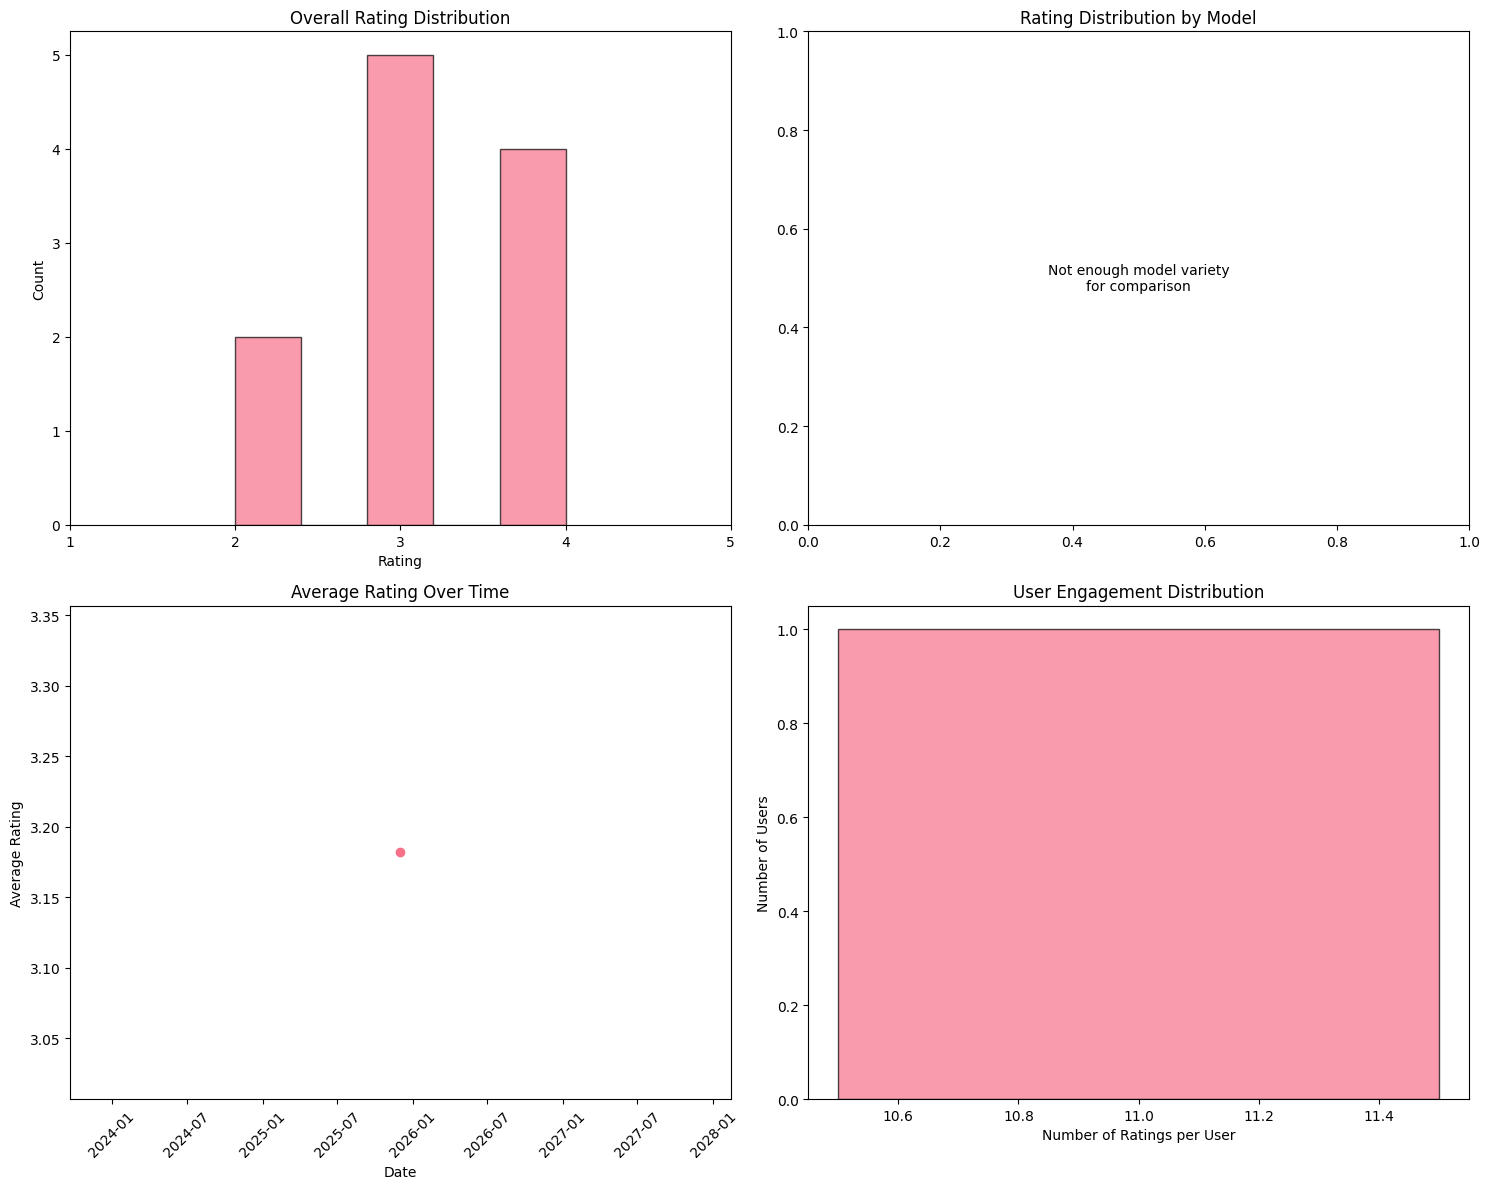

In [21]:
if ratings_df is not None and not ratings_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Overall rating distribution
    axes[0, 0].hist(ratings_df["rating"], bins=5, alpha=0.7, edgecolor="black")
    axes[0, 0].set_xlabel("Rating")
    axes[0, 0].set_ylabel("Count")
    axes[0, 0].set_title("Overall Rating Distribution")
    axes[0, 0].set_xticks([1, 2, 3, 4, 5])

    # Rating distribution by model
    if "model" in ratings_df.columns and ratings_df["model"].nunique() > 1:
        ratings_df.boxplot(column="rating", by="model", ax=axes[0, 1])
        axes[0, 1].set_title("Rating Distribution by Model")
        axes[0, 1].set_xlabel("Model")
        axes[0, 1].set_ylabel("Rating")
    else:
        axes[0, 1].text(
            0.5,
            0.5,
            "Not enough model variety\nfor comparison",
            ha="center",
            va="center",
            transform=axes[0, 1].transAxes,
        )
        axes[0, 1].set_title("Rating Distribution by Model")

    # Ratings over time
    daily_avg = (
        ratings_df.groupby("date")["rating"].agg(["mean", "count"]).reset_index()
    )
    axes[1, 0].plot(daily_avg["date"], daily_avg["mean"], marker="o")
    axes[1, 0].set_xlabel("Date")
    axes[1, 0].set_ylabel("Average Rating")
    axes[1, 0].set_title("Average Rating Over Time")
    axes[1, 0].tick_params(axis="x", rotation=45)

    # Rating counts per user
    user_counts = ratings_df["user_email"].value_counts()
    axes[1, 1].hist(
        user_counts, bins=min(20, len(user_counts)), alpha=0.7, edgecolor="black"
    )
    axes[1, 1].set_xlabel("Number of Ratings per User")
    axes[1, 1].set_ylabel("Number of Users")
    axes[1, 1].set_title("User Engagement Distribution")

    plt.tight_layout()
    plt.show()

## Model Performance Comparison

In [22]:
if ratings_df is not None and not ratings_df.empty and "model" in ratings_df.columns:
    # Model performance statistics
    model_stats = (
        ratings_df.groupby("model")["rating"]
        .agg(["count", "mean", "median", "std", "min", "max"])
        .round(2)
    )

    print("=== MODEL PERFORMANCE COMPARISON ===")
    display(model_stats)

    # Statistical significance testing (if multiple models)
    if len(model_stats) > 1:
        from scipy import stats

        models = ratings_df["model"].unique()
        print("\n=== STATISTICAL SIGNIFICANCE TESTS (Mann-Whitney U) ===")

        for i, model1 in enumerate(models):
            for model2 in models[i + 1 :]:
                group1 = ratings_df[ratings_df["model"] == model1]["rating"]
                group2 = ratings_df[ratings_df["model"] == model2]["rating"]

                if len(group1) > 0 and len(group2) > 0:
                    statistic, p_value = stats.mannwhitneyu(
                        group1, group2, alternative="two-sided"
                    )
                    significance = (
                        "***"
                        if p_value < 0.001
                        else "**"
                        if p_value < 0.01
                        else "*"
                        if p_value < 0.05
                        else "ns"
                    )
                    print(f"{model1} vs {model2}: p={p_value:.4f} {significance}")

    # Visualization
    if len(model_stats) > 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Bar plot of average ratings
        model_stats["mean"].plot(kind="bar", ax=ax1, color="skyblue", alpha=0.8)
        ax1.set_title("Average Rating by Model")
        ax1.set_ylabel("Average Rating")
        ax1.set_xlabel("Model")
        ax1.tick_params(axis="x", rotation=45)
        ax1.grid(axis="y", alpha=0.3)

        # Add error bars
        ax1.errorbar(
            range(len(model_stats)),
            model_stats["mean"],
            yerr=model_stats["std"],
            fmt="none",
            color="black",
            capsize=5,
        )

        # Box plot
        sns.boxplot(data=ratings_df, x="model", y="rating", ax=ax2)
        ax2.set_title("Rating Distribution by Model")
        ax2.set_xlabel("Model")
        ax2.set_ylabel("Rating")
        ax2.tick_params(axis="x", rotation=45)

        plt.tight_layout()
        plt.show()

=== MODEL PERFORMANCE COMPARISON ===


,count,mean,median,std,min,max
model,,,,,,
Unknown,11,3.18,3.0,0.75,2,4


## Audio File Analysis

In [23]:
if ratings_df is not None and not ratings_df.empty:
    # Top and bottom rated audio files
    audio_stats = (
        ratings_df.groupby("audio_file")["rating"]
        .agg(["count", "mean", "std"])
        .round(2)
    )

    # Filter files with at least 3 ratings for reliability
    reliable_audio = (
        audio_stats[audio_stats["count"] >= 3].copy()
        if len(audio_stats) > 0
        else audio_stats.copy()
    )

    if len(reliable_audio) > 0:
        print("=== TOP RATED AUDIO FILES (≥3 ratings) ===")
        top_audio = reliable_audio.nlargest(10, "mean")
        display(top_audio)

        print("\n=== LOWEST RATED AUDIO FILES (≥3 ratings) ===")
        bottom_audio = reliable_audio.nsmallest(10, "mean")
        display(bottom_audio)

        # Visualization of audio file performance
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # Distribution of average ratings per audio file
        ax1.hist(reliable_audio["mean"], bins=20, alpha=0.7, edgecolor="black")
        ax1.set_xlabel("Average Rating")
        ax1.set_ylabel("Number of Audio Files")
        ax1.set_title("Distribution of Average Ratings per Audio File")
        ax1.axvline(
            reliable_audio["mean"].mean(),
            color="red",
            linestyle="--",
            label=f"Overall Mean: {reliable_audio['mean'].mean():.2f}",
        )
        ax1.legend()

        # Rating count vs average rating
        ax2.scatter(reliable_audio["count"], reliable_audio["mean"], alpha=0.6)
        ax2.set_xlabel("Number of Ratings")
        ax2.set_ylabel("Average Rating")
        ax2.set_title("Rating Count vs Average Rating per Audio File")
        ax2.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data for reliable audio file analysis.")

Not enough data for reliable audio file analysis.


## Advanced Analysis

=== RATING BIAS ANALYSIS ===
User rating averages range: 3.18 - 3.18
Standard deviation of user averages: nan

Potentially harsh users (0): []...
Potentially generous users (0): []...

Consistent users (low std): 0
Variable users (high std): 0


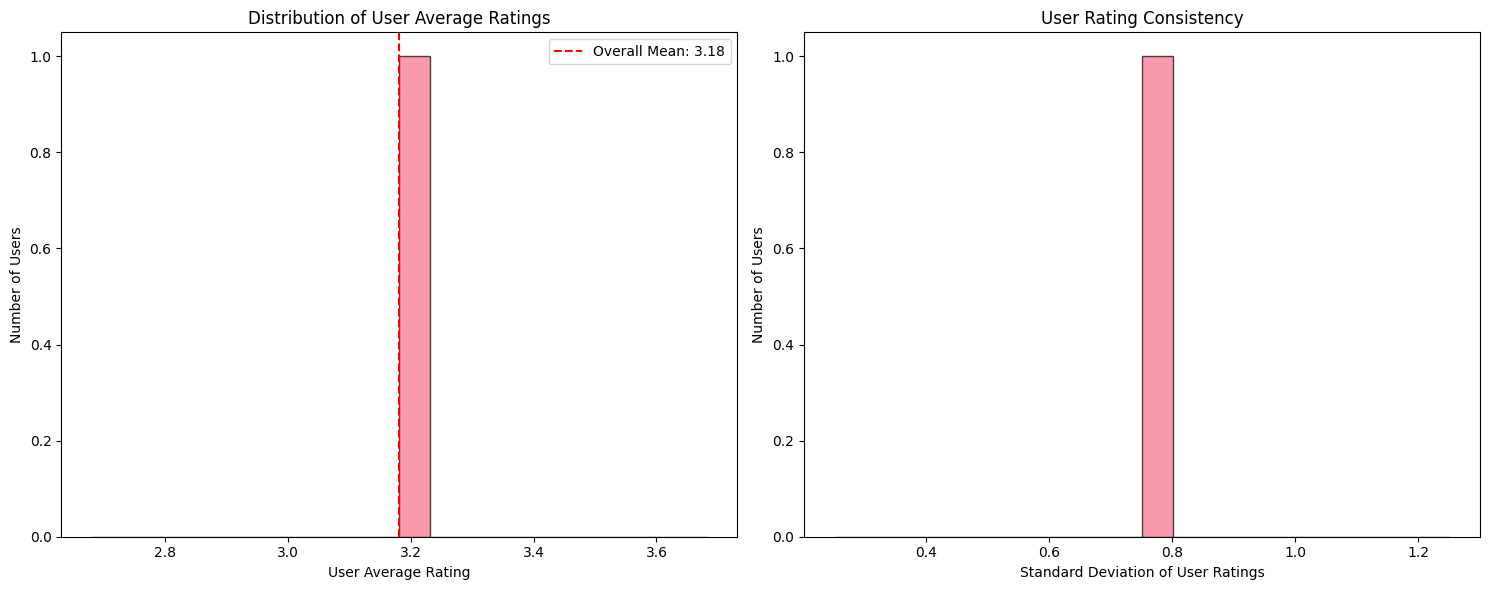

In [24]:
if ratings_df is not None and not ratings_df.empty and len(ratings_df) > 10:
    # Rating bias analysis
    print("=== RATING BIAS ANALYSIS ===")

    # Check for user rating bias
    user_avg_ratings = ratings_df.groupby("user_email")["rating"].mean()
    print(
        f"User rating averages range: {user_avg_ratings.min():.2f} - {user_avg_ratings.max():.2f}"
    )
    print(f"Standard deviation of user averages: {user_avg_ratings.std():.2f}")

    # Identify potentially biased users
    harsh_users = user_avg_ratings[
        user_avg_ratings < (user_avg_ratings.mean() - user_avg_ratings.std())
    ]
    generous_users = user_avg_ratings[
        user_avg_ratings > (user_avg_ratings.mean() + user_avg_ratings.std())
    ]

    print(
        f"\nPotentially harsh users ({len(harsh_users)}): {list(harsh_users.index[:3])}..."
    )
    print(
        f"Potentially generous users ({len(generous_users)}): {list(generous_users.index[:3])}..."
    )

    # Rating consistency analysis
    user_rating_std = ratings_df.groupby("user_email")["rating"].std().fillna(0)
    consistent_users = user_rating_std[user_rating_std < 0.5]
    variable_users = user_rating_std[user_rating_std > 1.5]

    print(f"\nConsistent users (low std): {len(consistent_users)}")
    print(f"Variable users (high std): {len(variable_users)}")

    # Visualization of user biases
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # User average ratings distribution
    ax1.hist(user_avg_ratings, bins=20, alpha=0.7, edgecolor="black")
    ax1.axvline(
        user_avg_ratings.mean(),
        color="red",
        linestyle="--",
        label=f"Overall Mean: {user_avg_ratings.mean():.2f}",
    )
    ax1.set_xlabel("User Average Rating")
    ax1.set_ylabel("Number of Users")
    ax1.set_title("Distribution of User Average Ratings")
    ax1.legend()

    # User rating consistency
    ax2.hist(user_rating_std, bins=20, alpha=0.7, edgecolor="black")
    ax2.set_xlabel("Standard Deviation of User Ratings")
    ax2.set_ylabel("Number of Users")
    ax2.set_title("User Rating Consistency")

    plt.tight_layout()
    plt.show()

## Export Results

In [25]:
# if ratings_df is not None and not ratings_df.empty:
#     # Create summary report
#     summary_report = {
#         'total_ratings': len(ratings_df),
#         'unique_users': ratings_df['user_email'].nunique(),
#         'unique_audio_files': ratings_df['audio_file'].nunique(),
#         'average_rating': ratings_df['rating'].mean(),
#         'median_rating': ratings_df['rating'].median(),
#         'rating_std': ratings_df['rating'].std(),
#         'date_range_start': ratings_df['timestamp'].min().strftime('%Y-%m-%d'),
#         'date_range_end': ratings_df['timestamp'].max().strftime('%Y-%m-%d'),
#     }

#     # Export processed data
#     output_dir = '../data/processed'
#     os.makedirs(output_dir, exist_ok=True)

#     # Save processed ratings data
#     ratings_df.to_csv(f'{output_dir}/ratings_analysis.csv', index=False)
#     print(f"Processed ratings data saved to: {output_dir}/ratings_analysis.csv")

#     # Save summary statistics
#     if 'model' in ratings_df.columns:
#         model_stats = ratings_df.groupby('model')['rating'].agg([
#             'count', 'mean', 'median', 'std', 'min', 'max'
#         ]).round(3)
#         model_stats.to_csv(f'{output_dir}/model_performance.csv')
#         print(f"Model performance stats saved to: {output_dir}/model_performance.csv")

#     # Save audio file statistics
#     audio_stats = ratings_df.groupby('audio_file')['rating'].agg([
#         'count', 'mean', 'std'
#     ]).round(3)
#     audio_stats.to_csv(f'{output_dir}/audio_file_stats.csv')
#     print(f"Audio file statistics saved to: {output_dir}/audio_file_stats.csv")

#     # Save user statistics
#     user_stats = ratings_df.groupby('user_email')['rating'].agg([
#         'count', 'mean', 'std'
#     ]).round(3)
#     user_stats.to_csv(f'{output_dir}/user_behavior_stats.csv')
#     print(f"User behavior statistics saved to: {output_dir}/user_behavior_stats.csv")

#     print("\n=== ANALYSIS COMPLETE ===")
#     print(f"Summary: {summary_report['total_ratings']} ratings from {summary_report['unique_users']} users")
#     print(f"Average rating: {summary_report['average_rating']:.2f}/5.0")
#     print(f"Data collection period: {summary_report['date_range_start']} to {summary_report['date_range_end']}")

## Conclusions and Recommendations

This notebook provides a comprehensive analysis of the TTS rating app votes. Key insights include:

1. **Overall Performance**: Average rating across all models and audio files
2. **Model Comparison**: Statistical comparison of different TTS models
3. **User Behavior**: Analysis of rating patterns and user engagement
4. **Quality Assessment**: Identification of best and worst performing audio files
5. **Bias Detection**: Analysis of user rating biases and consistency

### Next Steps:
- Continue collecting more data to increase statistical significance
- Consider implementing inter-annotator agreement measures
- Analyze correlation between specific audio characteristics and ratings
- Implement A/B testing for model improvements